In [1]:
import os
from PIL import Image

import numpy as np
import pydicom
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import pydicom
from pydicom.dataelem import DataElement
import h5py
import dicom2nifti
import nibabel as nib

from src.config import Directories
from src.models import UNet
from src.dataset import apply_ct_abdomen_filter, extract_array_as_HU

In [2]:
def preprocess_slice(s, get_min_max=False):
    s = apply_ct_abdomen_filter(s)
    s = np.rot90(s, k=1)
    s_min, s_max = s.min(), s.max()
    s = (s - s_min) / (s_max - s_min + 1e-12)
    s = s.astype(np.float32)
    s = np.stack((s, s, s), axis=len(s.shape))
    if get_min_max:
        return s, s_min, s_max
    else:
        return s

# Convert to Niftii

In [3]:
patients = [f for f in sorted(os.listdir(Directories.BASELINES)) if 'patient' in f]
output_dir = os.path.join(Directories.BASELINES, 'niftii_output')
if not os.path.exists(output_dir): os.makedirs(output_dir)

In [ ]:
# Convert to 'Niftii' volumes first because saving edited pixel arrays in a
# dicom object doesn't work properly (get garbage pixel arrays)    
for patient in patients:
    
    output_filepath = os.path.join(output_dir, f'{patient}.nii')
    patient_dir = os.path.join(Directories.BASELINES, patient, 'DICOM')
    try:
        dicom2nifti.dicom_series_to_nifti(patient_dir, output_filepath)
    except Exception as e:
        print(f"Can't convert {patient}: {e}")

# Segment Nii Volumes 

In [ ]:
unet_filename = 'unet_liver_2020-10-31_19:19:13.pth'
# unet_filename = 'model_25D.pht'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path_to_unet = os.path.join(Directories.CHECKPOINTS, unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet, map_location=device)['model_state_dict'])
# unet.load_state_dict(torch.load(path_to_unet, map_location=device))
unet.to(device)

cc = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
niftii_path = os.path.join(output_dir, 'patient029.nii')
niftii_object = nib.load(niftii_path)
volume = niftii_object.get_fdata()
volume = preprocess_slice(volume)
im = (volume[:,:,126,:]*255).astype(np.uint8)
im = Image.fromarray(im)
# im.save('./real_tumor_slice0.png')

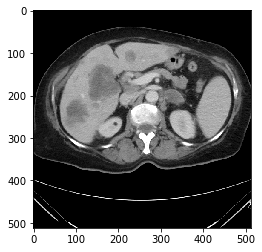

In [9]:
niftii_path = os.path.join(output_dir, 'patient439.nii')
niftii_object = nib.load(niftii_path)
volume = niftii_object.get_fdata()
volume = preprocess_slice(volume)
im = (volume[:,:,75,:]*255).astype(np.uint8)
im = Image.fromarray(im)
im.save('./real_tumor_slice2.png')
plt.imshow(im)

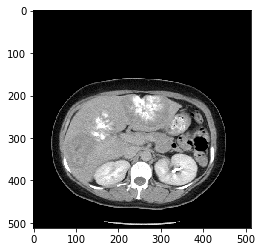

In [71]:
niftii_path = os.path.join(output_dir, 'patient000.nii')
niftii_object = nib.load(niftii_path)
volume = niftii_object.get_fdata()
volume = preprocess_slice(volume)
im = (volume[:,:,25,:]*255).astype(np.uint8)
im = Image.fromarray(im)
im.save('./real_tumor_slice2.png')
plt.imshow(im)

In [ ]:
%%time
desired_patients = ['patient000.nii', 'patient029.nii', 'patient053.nii', 
                    'patient073.nii', 'patient128.nii', 'patient439.nii',
                    'patient483.nii']
# desired_patients = ['patient000.nii']
# niftii_filenames = [n for n in os.listdir(output_dir) if n in desired_patients]
for niftii_filename in desired_patients:
    
    niftii_path = os.path.join(output_dir, niftii_filename)
    niftii_object = nib.load(niftii_path)
    
    volume = niftii_object.get_fdata()
    height, width, num_slices = volume.shape
    
    new_volume = np.zeros((height, width, num_slices), dtype=np.int16)
    volume, volume_min, volume_max = preprocess_slice(volume, True)
        
    for i in range(num_slices):
        cur_slice = volume[:, :, i, :]
        
        tensor = cc(cur_slice)
        tensor = tensor.unsqueeze(0)
        tensor = tensor.to(device)

        with torch.no_grad():
            out = unet(tensor)
        scores = F.softmax(out, dim=1)

        segmentation = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
        
        seg_liver = segmentation.unsqueeze(1).detach() * tensor
        seg_liver = seg_liver.squeeze().permute(1,2,0).detach().cpu().numpy()
        
        seg_liver = seg_liver * (volume_max - volume_min + 1e-12) + volume_min
        seg_liver = seg_liver.astype(np.int16)
        
        # Need to rotate to same alignment as niftii header parameters
        seg_liver = np.rot90(seg_liver, k=3)
        
        # Had to feed a 3-channel input to U-Net but values in each channel
        # are the same, hence we only need to index from the first channel
        new_volume[..., i] = seg_liver[..., 0]
        
    # Use the same affine and header since we want to preserve the original 
    # niftii volume parameters
    new_niftii_object = nib.nifti1.Nifti1Pair(new_volume, niftii_object.affine, 
                                              niftii_object.header)
    patient_name = os.path.splitext(niftii_filename)[0]
    output_path = os.path.join(output_dir, f'{patient_name}-segmented.nii')
    nib.save(new_niftii_object, output_path)

In [ ]:
tensor = cc(s)
tensor = tensor.unsqueeze(0)
tensor = tensor.to(device)

with torch.no_grad():
    out = unet(tensor)
scores = F.softmax(out, dim=1)

segmentation = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))
processed_arr = segmentation.unsqueeze(1).detach() * tensor

seg_liver = processed_arr.squeeze().permute(1,2,0).detach().cpu().numpy()

In [ ]:
processed_vol, vol_min, vol_max = preprocess_slice(volume, True)

# Treat all slices as one mini-batch for faster compute
tensor = torch.Tensor(processed_vol)
tensor = tensor.permute(2, 3, 0, 1)
tensor = tensor.to(device)

with torch.no_grad():
    out = unet(tensor)
scores = F.softmax(out, dim=1)

In [ ]:
scores.shape

In [ ]:
%%time
# desired_patients = ['patient000.nii', 'patient029.nii', 'patient053.nii', 
#                     'patient073.nii', 'patient128.nii', 'patient439.nii',
#                     'patient483.nii']
desired_patients = ['patient000.nii']
niftii_filenames = [n for n in os.listdir(output_dir) if n in desired_patients]
for niftii_filename in niftii_filenames:
    
    niftii_path = os.path.join(output_dir, niftii_filename)
    niftii_object = nib.load(niftii_path)
    
    volume = niftii_object.get_fdata()
    height, width, num_slices = volume.shape
    
    new_volume = np.zeros((height, width, num_slices), dtype=np.int16)
    
    processed_vol, vol_min, vol_max = preprocess_slice(volume, True)
    
    # Treat all slices as one mini-batch for faster compute
    tensor = torch.Tensor(processed_vol)
    tensor = tensor.permute(2, 3, 0, 1)
    tensor = tensor.to(device)

    with torch.no_grad():
        out = unet(tensor)
    scores = F.softmax(out, dim=1)
    
    for score in scores:
        segmentation = torch.round(F.threshold(scores[:, 1, :, :], 0.9, 0))

    seg_liver = segmentation.unsqueeze(1).detach() * tensor
    seg_liver = seg_liver.squeeze().permute(1,2,0).detach().cpu().numpy()

    seg_liver = seg_liver * (slice_max - slice_min + 1e-12) + slice_min
    seg_liver = seg_liver.astype(np.int16)

    # Need to rotate to same alignment as niftii header parameters
    seg_liver = np.rot90(seg_liver, k=3)

    # Had to feed a 3-channel input to U-Net but values in each channel
    # are the same, hence we only need to index from the first channel
    new_volume[..., i] = seg_liver[..., 0]
        
    # Use the same affine and header since we want to preserve the original 
    # niftii volume parameters
    new_niftii_object = nib.nifti1.Nifti1Pair(new_volume, niftii_object.affine, 
                                              niftii_object.header)
    patient_name = os.path.splitext(niftii_filename)[0]
    output_path = os.path.join(output_dir, f'{patient_name}-segmented.nii')
    nib.save(new_niftii_object, output_path)